# Load and Inspect the Dataset


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    4898.000000       4898.000000  4898.000000     4898.000000   
mean        6.854788          0.278241     0.334192        6.391415   
std         0.843868          0.100795     0.121020        5.072058   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.300000          0.210000     0.270000        1.700000   
50%         6.800000          0.260000     0.320000        5.200000   
75%         7.300000          0.320000     0.390000        9.900000   
max        14.200000          1.100000     1.660000       65.800000   

         chlorides  free sulfur dio

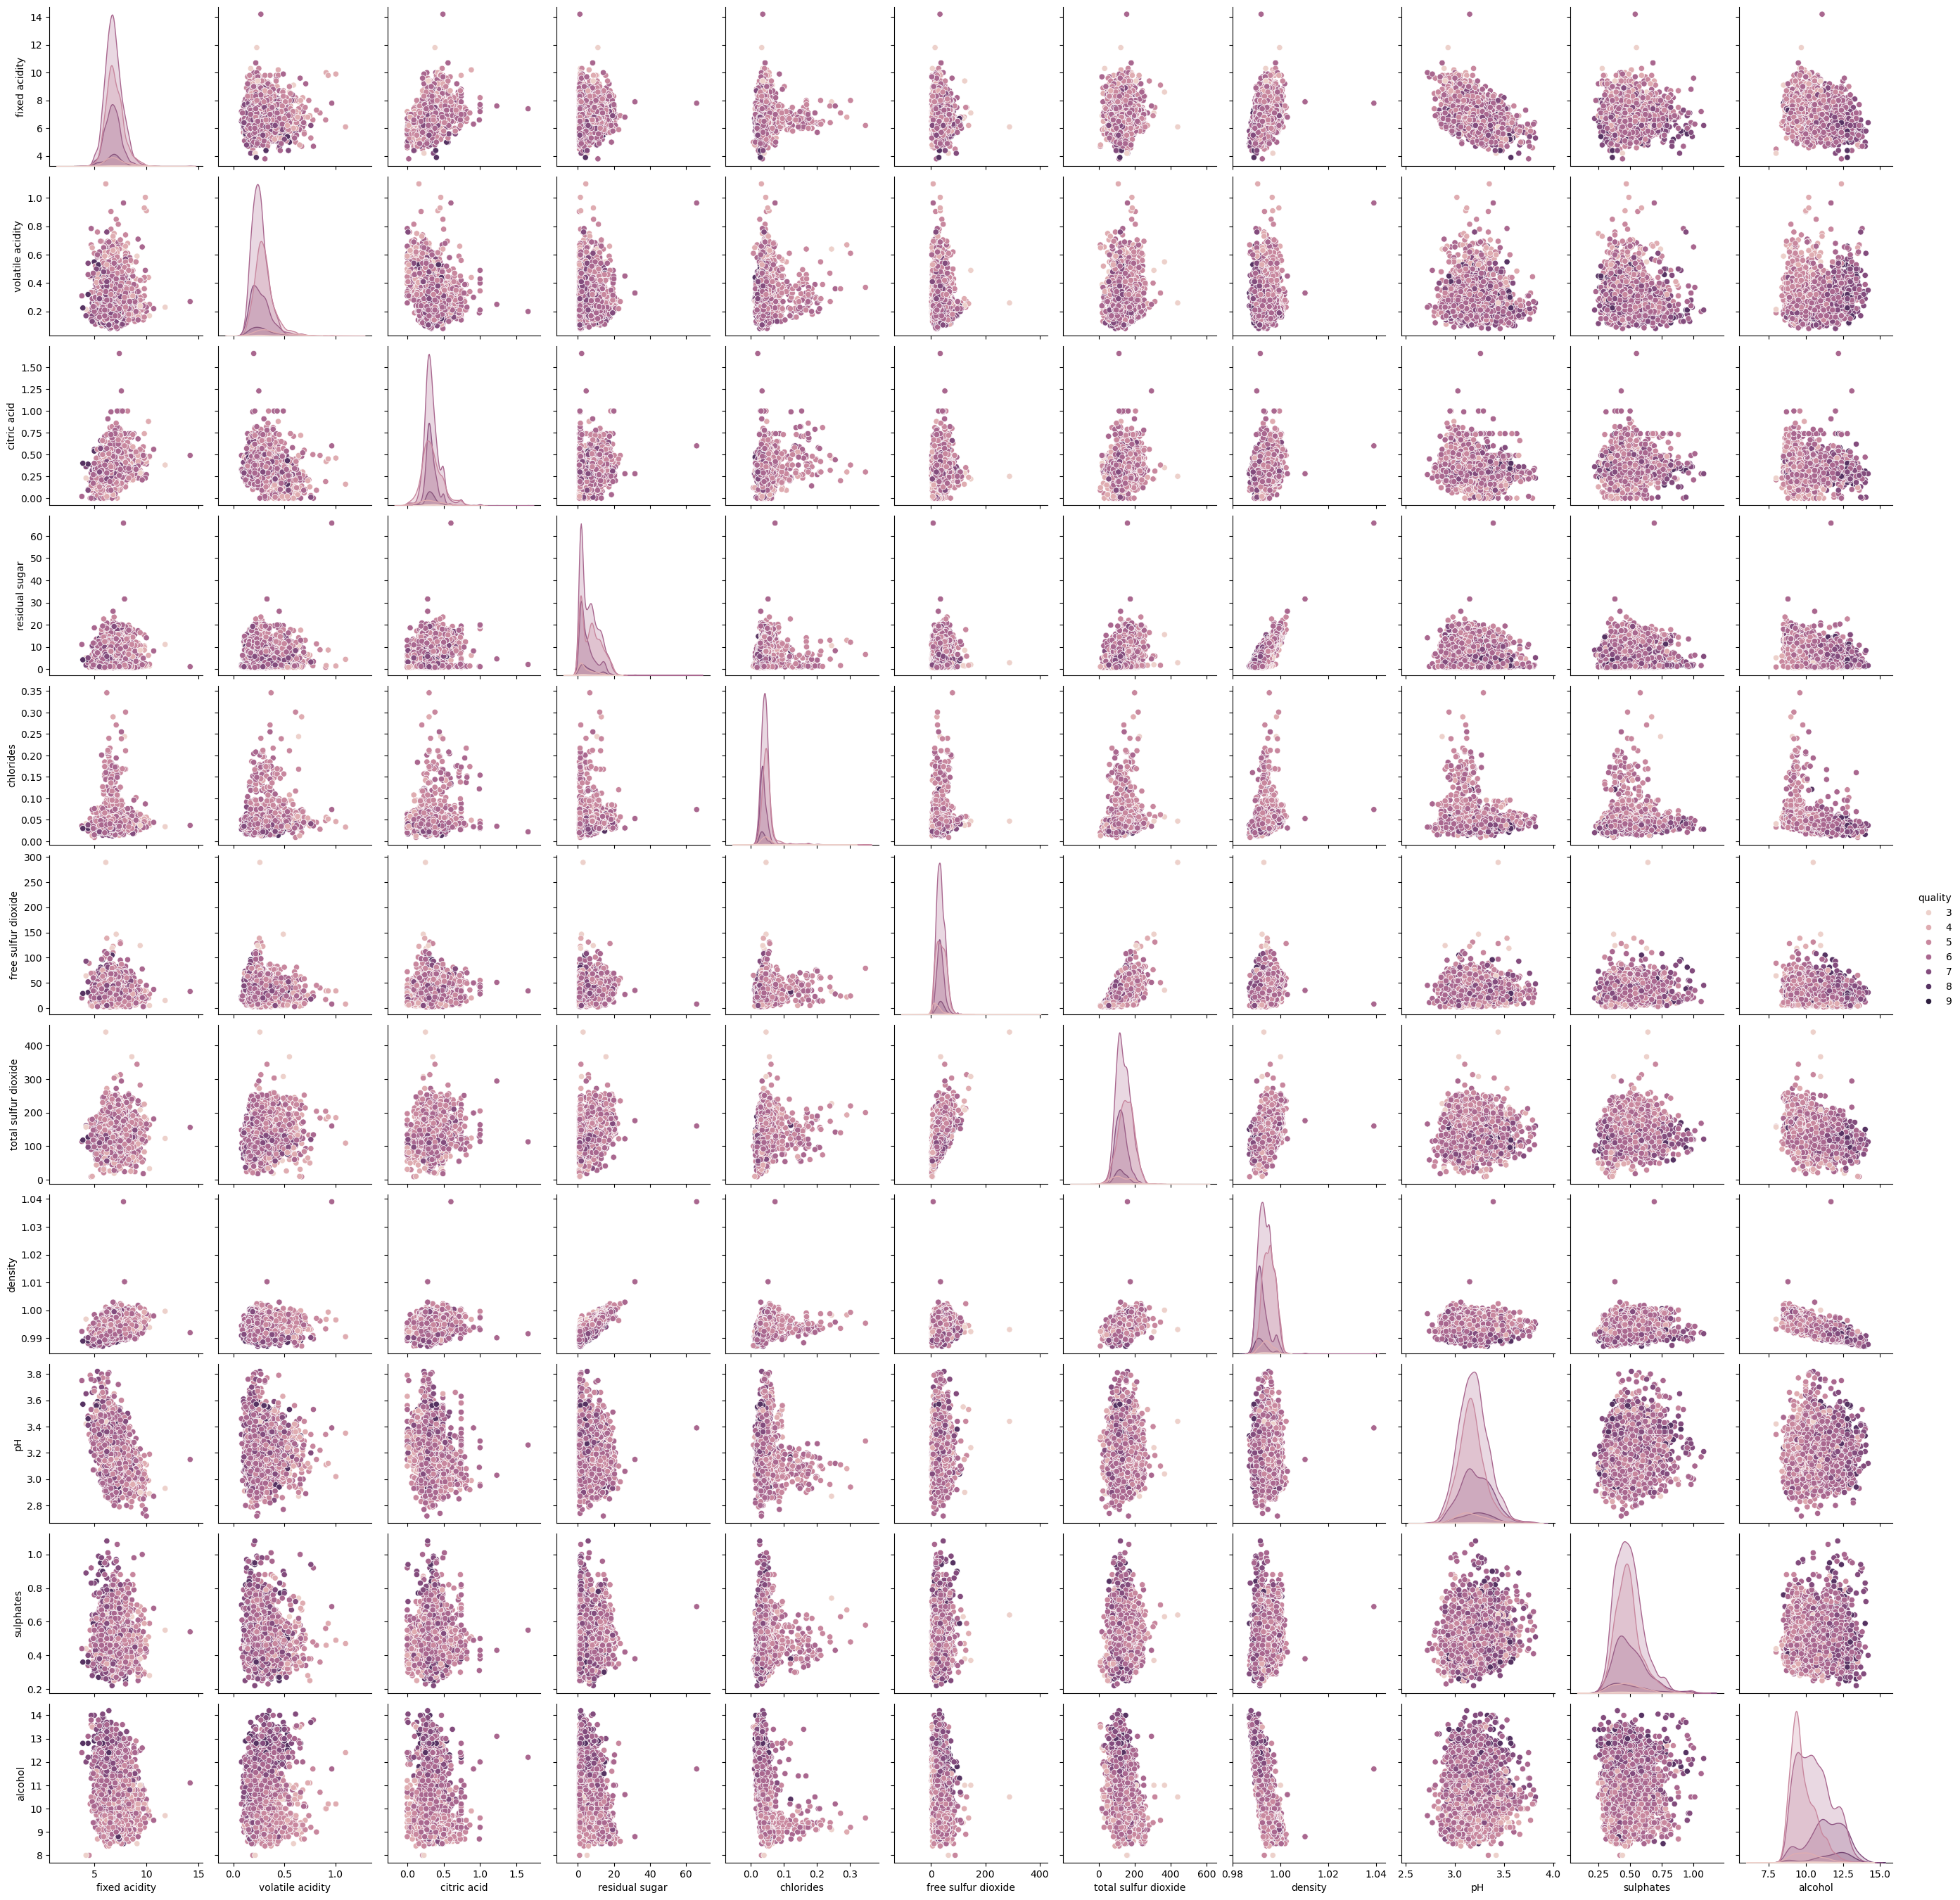

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


wine_data = pd.read_csv('wine.csv', delimiter=';')
print(wine_data.isnull().sum())


print(wine_data.describe())


sns.pairplot(wine_data, hue='quality', diag_kind='kde')
plt.show()


# Prepare the Data

In [55]:
from sklearn.preprocessing import StandardScaler


wine_data = pd.read_csv('wine.csv', delimiter=';')

X = wine_data.drop(columns=['quality'])  
y = wine_data['quality']  # 'quality' as the target label


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


print(X_scaled[:5])  


[[ 1.72096961e-01 -8.17699008e-02  2.13280202e-01  2.82134917e+00
  -3.53550004e-02  5.69931577e-01  7.44565035e-01  2.33151201e+00
  -1.24692128e+00 -3.49184257e-01 -1.39315246e+00]
 [-6.57501128e-01  2.15895632e-01  4.80011213e-02 -9.44765273e-01
   1.47747079e-01 -1.25301866e+00 -1.49684624e-01 -9.15417164e-03
   7.40028640e-01  1.34184656e-03 -8.24275678e-01]
 [ 1.47575110e+00  1.74519434e-02  5.43838363e-01  1.00282190e-01
   1.93522599e-01 -3.12141119e-01 -9.73335626e-01  3.58664800e-01
   4.75101984e-01 -4.36815783e-01 -3.36667007e-01]
 [ 4.09124986e-01 -4.78657278e-01 -1.17277959e-01  4.15768217e-01
   5.59726758e-01  6.87541270e-01  1.12109121e+00  5.25855242e-01
   1.14803354e-02 -7.87341887e-01 -4.99203231e-01]
 [ 4.09124986e-01 -4.78657278e-01 -1.17277959e-01  4.15768217e-01
   5.59726758e-01  6.87541270e-01  1.12109121e+00  5.25855242e-01
   1.14803354e-02 -7.87341887e-01 -4.99203231e-01]]


#  Implement Parameter-Free Clustering
# We'll begin by implementing the DSet algorithm for initial cluster extraction.

In [57]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import StandardScaler
import pandas as pd


wine_data = pd.read_csv('wine.csv', delimiter=';')

X = wine_data.drop(columns=['quality']) 
y = wine_data['quality'] 


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


sigma = 1.0 
similarity_matrix = rbf_kernel(X_scaled, gamma=1/(2*sigma**2))


def dominant_set(similarity_matrix, epsilon=1e-5):
    n = similarity_matrix.shape[0]
    weights = np.ones(n) / n  
    while True:
        new_weights = weights * np.dot(similarity_matrix, weights)
        new_weights /= new_weights.sum()
        if np.linalg.norm(new_weights - weights) < epsilon:
            break
        weights = new_weights
    return weights

# Extract dominant sets
weights = dominant_set(similarity_matrix)
print("Dominant set weights:", weights)


Dominant set weights: [1.46871763e-281 2.71988153e-050 1.02610875e-059 ... 3.83428120e-047
 3.20136521e-090 9.40574169e-056]


# Expand Clusters Using Density Peaks
# implement the Density Peak (DP) algorithm for cluster expansion.

In [59]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler


wine_data = pd.read_csv('wine.csv', delimiter=';')


X = wine_data.drop(columns=['quality'])  
y = wine_data['quality']  

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


def compute_density(X, k=5):
    neighbors = NearestNeighbors(n_neighbors=k).fit(X)
    distances, _ = neighbors.kneighbors(X)
    density = 1 / (distances[:, -1] + 1e-5)  
    return density

# Compute densities and identify density peaks
densities = compute_density(X_scaled)
density_peaks = X_scaled[densities.argsort()[-3:]]  # Assuming 3 clusters (top 3 peaks)
print("Density peaks:", density_peaks)


Density peaks: [[ 6.46153012e-01 -1.17321019e+00 -5.30475661e-01  1.79601958e+00
   1.93522599e-01 -6.06165351e-01 -7.90859669e-02  1.46212172e+00
  -1.90923792e+00 -5.24447309e-01 -1.47442057e+00]
 [ 8.83181037e-01 -7.76322810e-01 -2.82557040e-01  1.53968719e+00
   4.68175718e-01  1.04037035e+00  1.74471268e+00  1.66275025e+00
  -3.19677985e-01 -2.61552731e-01 -1.31188435e+00]
 [ 6.46153012e-01 -8.75544654e-01 -2.82557040e-01  1.26363691e+00
   3.30849159e-01  7.75748539e-01  2.13300529e+00  1.52899789e+00
  -3.19677985e-01  1.34184656e-03 -1.14934812e+00]]


# Clustering Accuracy Comparison

In [61]:
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# Load the wine dataset (make sure to specify the correct delimiter)
wine_data = pd.read_csv('wine.csv', delimiter=';')


X = wine_data.drop(columns=['quality'])  
y = wine_data['quality']  


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


def dominant_set(similarity_matrix, epsilon=1e-5):
    n = similarity_matrix.shape[0]
    weights = np.ones(n) / n  # Initialize equal weights
    while True:
        new_weights = weights * np.dot(similarity_matrix, weights)
        new_weights /= new_weights.sum()
        if np.linalg.norm(new_weights - weights) < epsilon:
            break
        weights = new_weights
    return weights

sigma = 1.0
similarity_matrix = rbf_kernel(X_scaled, gamma=1/(2*sigma**2))
weights = dominant_set(similarity_matrix)


dset_labels = (weights > 0.5).astype(int)  



def compute_density(X, k=5):
    neighbors = NearestNeighbors(n_neighbors=k).fit(X)
    distances, _ = neighbors.kneighbors(X)
    density = 1 / (distances[:, -1] + 1e-5)  
    return density

# Compute densities
densities = compute_density(X_scaled)
density_peaks = X_scaled[densities.argsort()[-3:]]  # Assuming 3 clusters


dp_labels = np.zeros(len(X_scaled))
for i, peak in enumerate(density_peaks):
    distances = np.linalg.norm(X_scaled - peak, axis=1)
    dp_labels[np.argmin(distances)] = i + 1  


kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

def evaluate_clustering(X, labels, true_labels):
    silhouette = silhouette_score(X, labels)
    ari = adjusted_rand_score(true_labels, labels)
    return silhouette, ari


dset_silhouette, dset_ari = evaluate_clustering(X_scaled, dset_labels, y)


dp_silhouette, dp_ari = evaluate_clustering(X_scaled, dp_labels, y)


kmeans_silhouette, kmeans_ari = evaluate_clustering(X_scaled, kmeans_labels, y)


print("Clustering Accuracy Comparison:")
print(f"DSet: Silhouette Score = {dset_silhouette:.3f}, ARI = {dset_ari:.3f}")
print(f"Density Peak (DP): Silhouette Score = {dp_silhouette:.3f}, ARI = {dp_ari:.3f}")
print(f"k-Means: Silhouette Score = {kmeans_silhouette:.3f}, ARI = {kmeans_ari:.3f}")


Clustering Accuracy Comparison:
DSet: Silhouette Score = -0.235, ARI = 0.000
Density Peak (DP): Silhouette Score = -0.041, ARI = 0.001
k-Means: Silhouette Score = 0.144, ARI = 0.034


# Visualization of all the clusting used

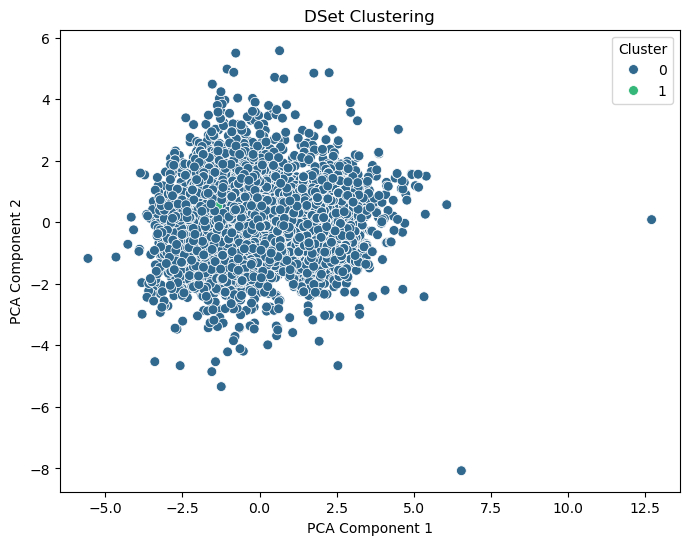

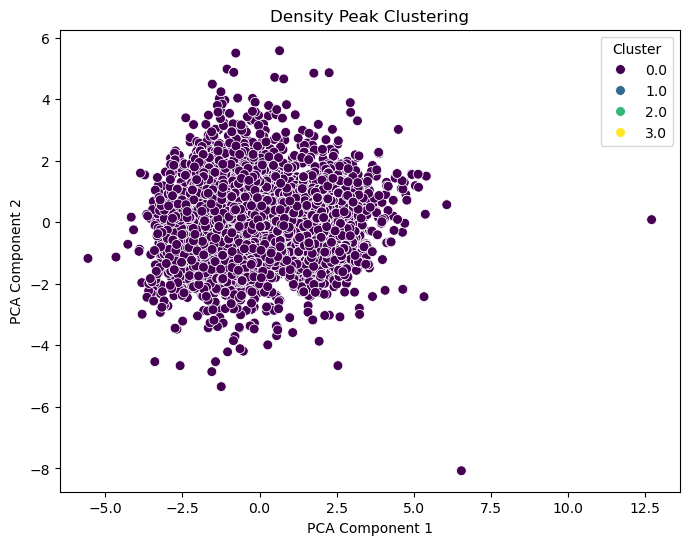

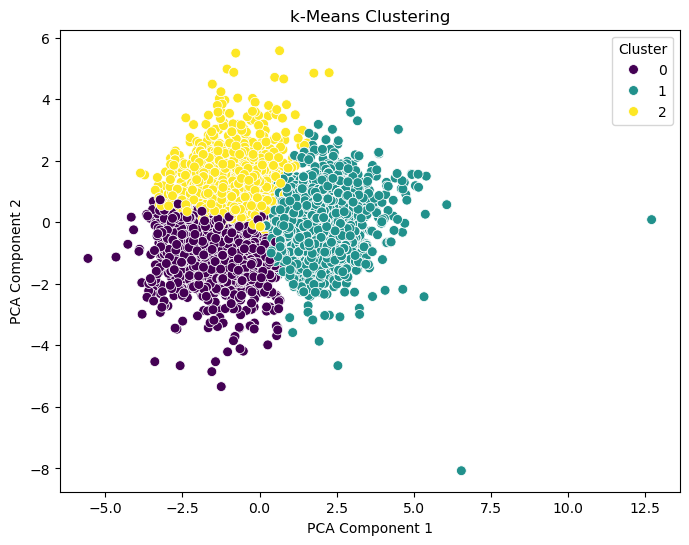

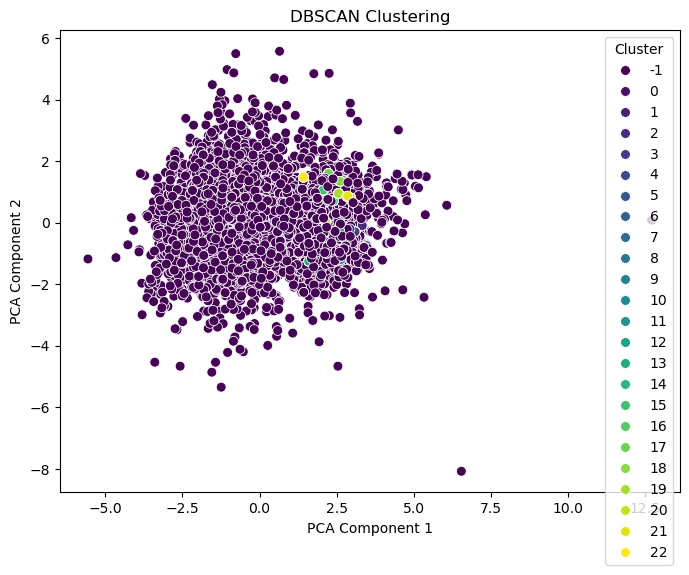

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


def visualize_clusters(X, labels, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette='viridis', s=50, legend='full')
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(loc="best", title="Cluster")
    plt.show()


dset_labels = (weights > 0.5).astype(int)  
visualize_clusters(X_pca, dset_labels, "DSet Clustering")


dp_labels = np.zeros(len(X_scaled))  
for i, peak in enumerate(density_peaks):
    distances = np.linalg.norm(X_scaled - peak, axis=1)
    dp_labels[np.argmin(distances)] = i + 1
visualize_clusters(X_pca, dp_labels, "Density Peak Clustering")


kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
visualize_clusters(X_pca, kmeans_labels, "k-Means Clustering")


dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)
visualize_clusters(X_pca, dbscan_labels, "DBSCAN Clustering")
